In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [14]:
# Load the dataset
df = pd.read_csv("household_power_consumption.txt", sep=';', 
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True, low_memory=False, na_values=['?'])

# Keep a single variable for forecasting
df = df[['datetime', 'Global_active_power']].dropna()
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Resample to hourly average
df_hourly = df.resample('H').mean()
df_hourly = df_hourly.fillna(method='ffill')

C:\Users\hp\AppData\Local\Temp\ipykernel_14348\3534128617.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv("household_power_consumption.txt", sep=';',
C:\Users\hp\AppData\Local\Temp\ipykernel_14348\3534128617.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("household_power_consumption.txt", sep=';',
C:\Users\hp\AppData\Local\Temp\ipykernel_14348\3534128617.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("household_power_consumption.txt", sep=';',
C:\Users\hp\AppData\L

In [15]:
df_feat = df_hourly.copy()
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['is_weekend'] = (df_feat['dayofweek'] >= 5).astype(int)

In [16]:
train = df_feat[:-168]
test = df_feat[-168:]

In [17]:
arima_model = ARIMA(train['Global_active_power'], order=(5,1,2))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=168)

arima_rmse = np.sqrt(mean_squared_error(test['Global_active_power'], arima_forecast))
print("ARIMA RMSE", arima_rmse)

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA RMSE 0.856938200117288


In [18]:
prophet_df = df_hourly.reset_index().rename(columns={'datetime':'ds', 'Global_active_power':'y'})
train_prophet = prophet_df[:-168]
test_prophet = prophet_df[-168:]

prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
prophet_model.fit(train_prophet)

future = prophet_model.make_future_dataframe(periods=168, freq='H')
prophet_pred = prophet_model.predict(future)
prophet_forecast = prophet_pred.set_index('ds')['yhat'][-168:]

prophet_rmse = np.sqrt(mean_squared_error(test_prophet['y'], prophet_forecast))
print("Prophet RMSE", prophet_rmse)

18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet RMSE 0.7555208577574439


In [19]:
def create_lags(data, lags=24):
    df = data.copy()
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df['Global_active_power'].shift(i)
    return df

df_lagged = create_lags(df_feat)
df_lagged = df_lagged.dropna()

train_x = df_lagged[:-168].drop('Global_active_power', axis=1)
train_y = df_lagged[:-168]['Global_active_power']
test_x = df_lagged[-168:].drop('Global_active_power', axis=1)
test_y = df_lagged[-168:]['Global_active_power']

xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1)
xgb_model.fit(train_x, train_y)

xgb_forecast = xgb_model.predict(test_x)
xgb_rmse = np.sqrt(mean_squared_error(test_y, xgb_forecast))
print("XGBoost RMSE", xgb_rmse)

XGBoost RMSE 0.5560432351181666


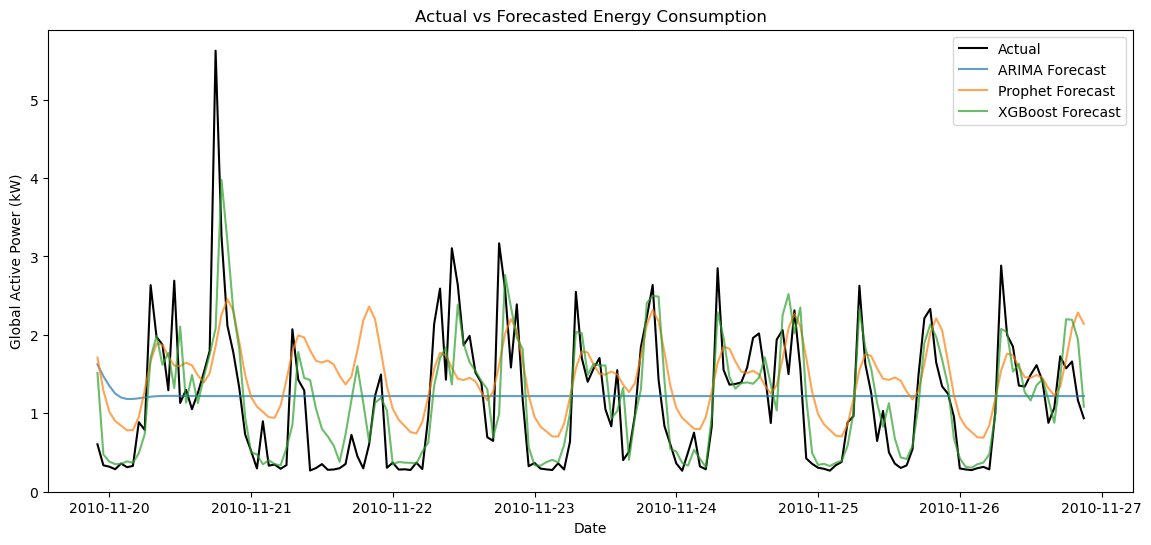

In [20]:
plt.figure(figsize=(14,6))

plt.plot(test.index, test['Global_active_power'], label="Actual", color="black")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast", alpha=0.7)
plt.plot(test.index, prophet_forecast, label="Prophet Forecast", alpha=0.7)
plt.plot(test.index, xgb_forecast, label="XGBoost Forecast", alpha=0.7)

plt.legend()
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.title("Actual vs Forecasted Energy Consumption")
plt.show()